In [8]:
import pandas as pd

# Load the dataset
data = pd.read_csv('reliance_stock_data.csv', parse_dates=['Date'], index_col='Date')

# Display the first few rows
print(data.head())

               Open    High      Low    Close  Adj_Close     Volume
Date                                                               
2025-04-07  1125.00  1171.0  1115.55  1166.20    1166.20  1433461.0
2025-04-04  1240.00  1245.2  1192.85  1204.70    1204.70   785059.0
2025-04-03  1238.95  1251.2  1234.55  1248.60    1248.60   532522.0
2025-04-02  1250.35  1256.0  1243.80  1251.10    1251.10   243303.0
2025-04-01  1274.60  1277.8  1250.00  1252.45    1252.45   722008.0


In [9]:
# Sort the dataset by Date in ascending order
data = data.sort_index()

# Verify that the index is sorted
print(data.index.is_monotonic_increasing)  # Should return True

True


In [ ]:
# Split data into training and testing sets based on date
train = data.loc['2023-01-09':'2024-12-31']
test = data.loc['2025-01-01':]

# Display training and testing sets
print("Training Set:")
print(train.head())
print("\nTesting Set:")
print(test.head())

In [ ]:
import pandas as pd
import numpy as np
!pip install statsmodels
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Load stock price data
stock_data = pd.read_csv('reliance_stock_data.csv')
stock_data['Date'] = pd.to_datetime(stock_data['Date'], format='%Y-%m-%d')
stock_data.set_index('Date', inplace=True)
stock_data.sort_index(inplace=True)

# Load sentiment data with error handling
try:
    sentiment_data = pd.read_csv('new_articles_with_ewma.csv', on_bad_lines='skip')
except pd.errors.ParserError:
    sentiment_data = pd.read_csv('new_articles_with_ewma.csv', error_bad_lines=False)

# Convert date column to datetime
sentiment_data['date'] = pd.to_datetime(sentiment_data['date'])

# SOLUTION FOR ISSUE #1:
# Group by date and take the last EWMA-3 value for each date
ewma_data = sentiment_data.groupby('date')['ewma_3'].last().reset_index()
ewma_data.rename(columns={'date': 'Date'}, inplace=True)
ewma_data.set_index('Date', inplace=True)
ewma_data.sort_index(inplace=True)

# SOLUTION FOR ISSUE #2:
# Join with stock data and forward fill missing values
merged_data = stock_data.join(ewma_data, how='left')

# Forward fill missing EWMA values (uses last available EWMA)
merged_data['ewma_3'].fillna(method='ffill', inplace=True)
# For any missing values at the beginning, backward fill
merged_data['ewma_3'].fillna(method='bfill', inplace=True)

# Print the first few rows to verify the data
print("First few rows of merged data:")
print(merged_data.head())

# Split data into training and testing sets
train_data = merged_data.loc[:'2024-12-31']
test_data = merged_data.loc['2025-01-01':'2025-03-31']

print(f"Training data shape: {train_data.shape}")
print(f"Testing data shape: {test_data.shape}")

# Define SARIMAX parameters
p, d, q = 1, 1, 1      # Non-seasonal parameters
P, D, Q, s = 1, 1, 1, 12   # Seasonal parameters (monthly seasonality)

# Prepare exogenous variables
train_exog = train_data[['ewma_3']]
test_exog = test_data[['ewma_3']]

# Fit SARIMAX model on training data with exogenous variable
print("Fitting SARIMAX model...")
model = SARIMAX(train_data['Close'],
                exog=train_exog,
                order=(p, d, q),
                seasonal_order=(P, D, Q, s),
                enforce_stationarity=False,
                enforce_invertibility=False)
sarimax_model = model.fit(disp=False)

# Print model summary
print("\nModel Summary:")
print(sarimax_model.summary())


<ipython-input-10-72b943d8b4db>:20: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  sentiment_data['date'] = pd.to_datetime(sentiment_data['date'])
<ipython-input-10-72b943d8b4db>:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_data['ewma_3'].fillna(method='ffill', inplace=True)
<ipython-input-10-72b943d8b4db>:34: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version.

First few rows of merged data:
               Open     High      Low    Close  Adj_Close    Volume    ewma_3
Date                                                                         
2023-01-09  1271.85  1300.90  1269.55  1298.28    1280.41  596984.0 -0.007061
2023-01-10  1302.03  1302.50  1273.03  1278.97    1261.38  305284.0 -0.007061
2023-01-11  1277.60  1279.10  1261.00  1262.75    1245.38  255590.0 -0.007061
2023-01-12  1262.50  1265.95  1232.82  1236.05    1219.04  370686.0 -0.007061
2023-01-13  1234.30  1236.60  1217.40  1233.68    1216.70  497964.0 -0.007061
Training data shape: (485, 7)
Testing data shape: (62, 7)
Fitting SARIMAX model...

Model Summary:
                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                  485
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1982.189
Date:                            Tue, 08 Apr 2025  

In [11]:
# Forecast for the test set with exogenous variables
print("\nGenerating forecasts...")

# First, make sure the test_exog has the right dimensions
print(f"Test exog shape: {test_exog.shape}") # This should be (62, 1)

# Generate forecasts with the correct number of steps and exogenous variables
forecast = sarimax_model.get_forecast(steps=len(test_data), exog=test_exog)
forecast_mean = forecast.predicted_mean

print(f"Forecast shape: {forecast_mean.shape}") # This should be (62,)

# Important: Set the index of forecast_mean to match test_data's index
forecast_mean.index = test_data.index

print("forecast\n", forecast_mean.head())

# Now we can safely assign it to test_data
test_data['Predicted'] = forecast_mean

print("test data\n", test_data.head())
print("test data shape", test_data.shape)

test_data.to_csv('test_daata_with_pred.csv')


Generating forecasts...
Test exog shape: (62, 1)
Forecast shape: (62,)
forecast
 Date
2025-01-01    1214.116618
2025-01-02    1209.065188
2025-01-03    1207.897351
2025-01-06    1213.706453
2025-01-07    1217.512137
Name: predicted_mean, dtype: float64
test data
                Open    High      Low    Close  Adj_Close    Volume    ewma_3  \
Date                                                                           
2025-01-01  1218.95  1226.2  1212.10  1221.65    1221.65  380215.0 -0.059978   
2025-01-02  1220.70  1244.5  1220.25  1241.65    1241.65  529144.0 -0.087331   
2025-01-03  1247.75  1262.3  1235.60  1251.35    1251.35  502895.0 -0.086633   
2025-01-06  1251.55  1261.7  1215.30  1218.20    1218.20  782428.0 -0.092015   
2025-01-07  1221.65  1243.4  1221.40  1240.90    1240.90  512057.0 -0.048032   

              Predicted  
Date                     
2025-01-01  1214.116618  
2025-01-02  1209.065188  
2025-01-03  1207.897351  
2025-01-06  1213.706453  
2025-01-07  1217.5

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
<ipython-input-11-8dfba87d2a24>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Predicted'] = forecast_mean


In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Check for NaN in test_data['Close'] and test_data['Predicted']
print(f"NaN in test_data['Close']: {test_data['Close'].isnull().any()}")
print(f"NaN in test_data['Predicted']: {test_data['Predicted'].isnull().any()}")
print("test data",test_data.head())

# If there are NaNs, handle them before calculating MAE. For example:
test_data.dropna(subset=['Close', 'Predicted'], inplace=True)

# Calculate performance metrics
mae = mean_absolute_error(test_data['Close'], test_data['Predicted'])
mape = (abs((test_data['Close'] - test_data['Predicted']) / test_data['Close']).mean()) * 100
rmse = np.sqrt(mean_squared_error(test_data['Close'], test_data['Predicted']))

print(f"\nPerformance Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")



NaN in test_data['Close']: False
NaN in test_data['Predicted']: False
test data                Open    High      Low    Close  Adj_Close    Volume    ewma_3  \
Date                                                                           
2025-01-01  1218.95  1226.2  1212.10  1221.65    1221.65  380215.0 -0.059978   
2025-01-02  1220.70  1244.5  1220.25  1241.65    1241.65  529144.0 -0.087331   
2025-01-03  1247.75  1262.3  1235.60  1251.35    1251.35  502895.0 -0.086633   
2025-01-06  1251.55  1261.7  1215.30  1218.20    1218.20  782428.0 -0.092015   
2025-01-07  1221.65  1243.4  1221.40  1240.90    1240.90  512057.0 -0.048032   

              Predicted  
Date                     
2025-01-01  1214.116618  
2025-01-02  1209.065188  
2025-01-03  1207.897351  
2025-01-06  1213.706453  
2025-01-07  1217.512137  

Performance Metrics:
Mean Absolute Error (MAE): 56.00
Mean Absolute Percentage Error (MAPE): 4.45%
Root Mean Squared Error (RMSE): 64.46


<ipython-input-13-1d8648d86e0f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.dropna(subset=['Close', 'Predicted'], inplace=True)


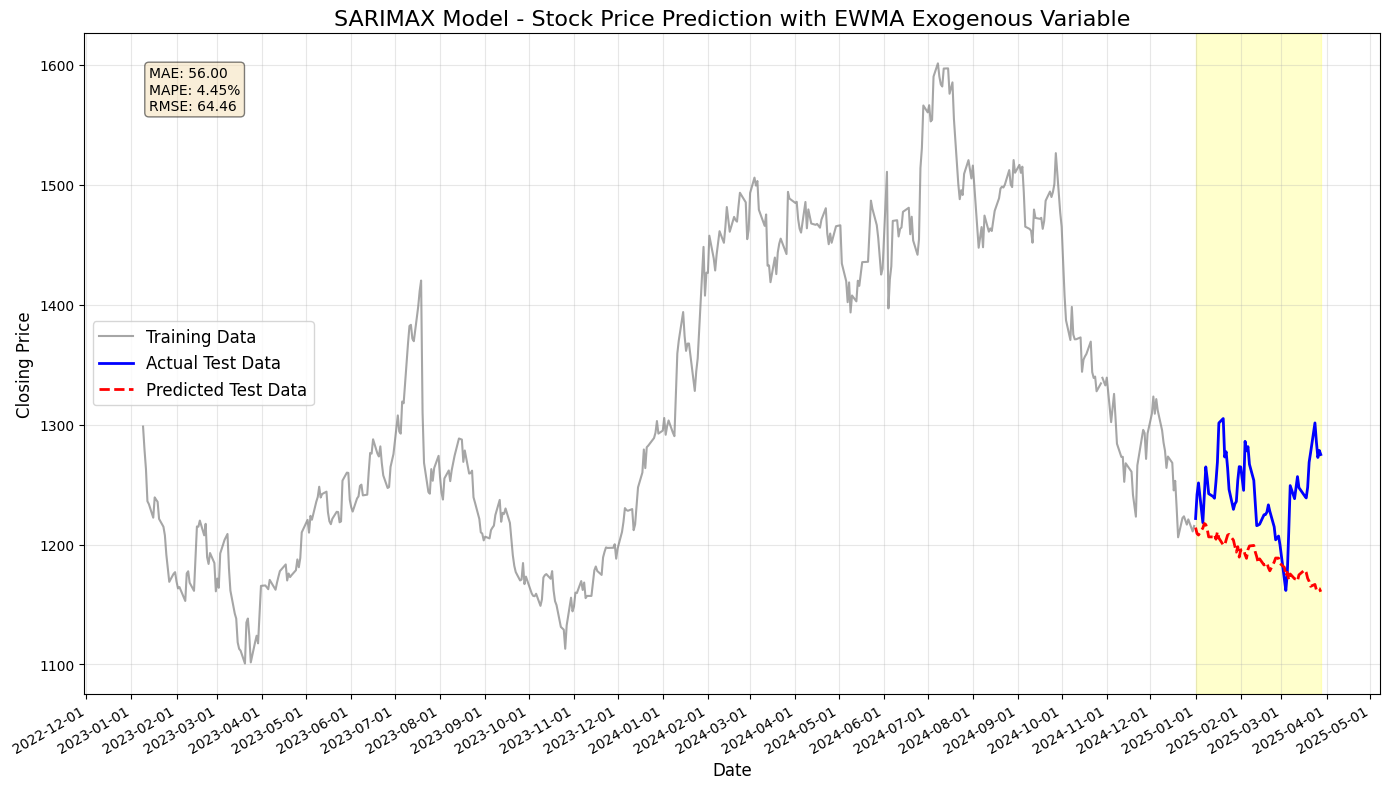


Predictions saved to 'sarimax_predictions.csv'


In [16]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Plot actual vs predicted values
plt.figure(figsize=(14, 8))

# Plot training data
plt.plot(train_data.index, train_data['Close'], label='Training Data', color='gray', alpha=0.7)

# Plot test data and predictions
plt.plot(test_data.index, test_data['Close'], label='Actual Test Data', color='blue', linewidth=2)
plt.plot(test_data.index, test_data['Predicted'], label='Predicted Test Data', color='red', linewidth=2, linestyle='--')

# Enhance the plot
plt.title('SARIMAX Model - Stock Price Prediction with EWMA Exogenous Variable', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Closing Price', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)

# Format x-axis dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()

# Add text box with performance metrics
textstr = f"MAE: {mae:.2f}\nMAPE: {mape:.2f}%\nRMSE: {rmse:.2f}"
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.annotate(textstr, xy=(0.05, 0.95), xycoords='axes fraction',
             bbox=props, fontsize=10, verticalalignment='top')

# Highlight the forecast period
min_y = min(min(train_data['Close']), min(test_data['Close']), min(test_data['Predicted'])) * 0.95
max_y = max(max(train_data['Close']), max(test_data['Close']), max(test_data['Predicted'])) * 1.05
plt.axvspan(test_data.index[0], test_data.index[-1], alpha=0.2, color='yellow', label='Forecast Period')

plt.tight_layout()
plt.savefig('sarimax_stock_prediction.png', dpi=300)
plt.show()

# Create a DataFrame with the predictions for easy export
prediction_df = pd.DataFrame({
    'Date': test_data.index,
    'Actual_Close': test_data['Close'],
    'Predicted_Close': test_data['Predicted'],
    'EWMA_3': test_data['ewma_3']
})

# Save predictions to CSV
prediction_df.to_csv('sarimax_predictions.csv')
print("\nPredictions saved to 'sarimax_predictions.csv'")